In [1]:
# import exploratory data analysis libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import scikit-learn modules
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.model_selection import cross_val_score, train_test_split, KFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.decomposition import PCA
from sklearn.multioutput import MultiOutputRegressor
from sklearn.inspection import permutation_importance

In [2]:
df1 = pd.read_csv('Video_Games_1.csv')
# df2a = pd.read_csv('game_info_2.csv')
# df3a = pd.read_csv('vgchartz-2024_3.csv')

In [3]:
# inspect df1
print(df1.shape)
print("\n", df1.info())

(16928, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16928 entries, 0 to 16927
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16928 non-null  int64  
 1   Name             16926 non-null  object 
 2   Platform         16928 non-null  object 
 3   Year_of_Release  16655 non-null  float64
 4   Genre            16926 non-null  object 
 5   Publisher        16873 non-null  object 
 6   NA_Sales         16928 non-null  float64
 7   EU_Sales         16928 non-null  float64
 8   JP_Sales         16928 non-null  float64
 9   Other_Sales      16928 non-null  float64
 10  Global_Sales     16928 non-null  float64
 11  Critic_Score     8260 non-null   float64
 12  Critic_Count     8260 non-null   float64
 13  User_Score       10159 non-null  object 
 14  User_Count       7718 non-null   float64
 15  Developer        10240 non-null  object 
 16  Rating           10092 non-null  object 
dtype

In [4]:
# inspect summary stats for df1
print(df1.describe())

              index  Year_of_Release      NA_Sales      EU_Sales  \
count  16928.000000      16655.00000  16928.000000  16928.000000   
mean    8463.500000       2006.48532      0.266390      0.146850   
std     4886.837014          5.88289      0.814326      0.504585   
min        0.000000       1980.00000      0.000000      0.000000   
25%     4231.750000       2003.00000      0.000000      0.000000   
50%     8463.500000       2007.00000      0.080000      0.020000   
75%    12695.250000       2010.00000      0.240000      0.110000   
max    16927.000000       2020.00000     41.360000     28.960000   

           JP_Sales   Other_Sales  Global_Sales  Critic_Score  Critic_Count  \
count  16928.000000  16928.000000  16928.000000   8260.000000   8260.000000   
mean       0.078170      0.047861      0.539520     69.037893     26.428692   
std        0.308756      0.186675      1.550545     13.943198     18.989929   
min        0.000000      0.000000      0.010000     13.000000      3.00

In [5]:
# examine User_Score column
print(df1['User_Score'].value_counts().sort_values())

User_Score
9.7       1
0         1
0.9       2
1.3       2
0.7       2
       ... 
8.3     259
8.2     285
8       296
7.8     326
tbd    2441
Name: count, Length: 96, dtype: int64


In [6]:
print(df1['Publisher'].value_counts().sort_values())

print(df1['Publisher'].nunique())

Publisher
UIG Entertainment                  1
Naxat Soft                         1
Panther Software                   1
T&E Soft                           1
NDA Productions                    1
                                ... 
Konami Digital Entertainment     839
Ubisoft                          948
Namco Bandai Games               952
Activision                      1003
Electronic Arts                 1389
Name: count, Length: 581, dtype: int64
581


In [7]:
# replace 'tbd' values with nulls
df1['User_Score'] = df1['User_Score'].replace('tbd', None)

# convert User_score from object to float
df1['User_Score'] = df1['User_Score'].astype(float)

In [8]:
# make User_Score same scale as Critic Score
df1['User_Score'] = df1['User_Score'] * 10

print(df1['User_Score'].describe())

count    7718.000000
mean       71.259264
std        14.988857
min         0.000000
25%        64.000000
50%        75.000000
75%        82.000000
max        97.000000
Name: User_Score, dtype: float64


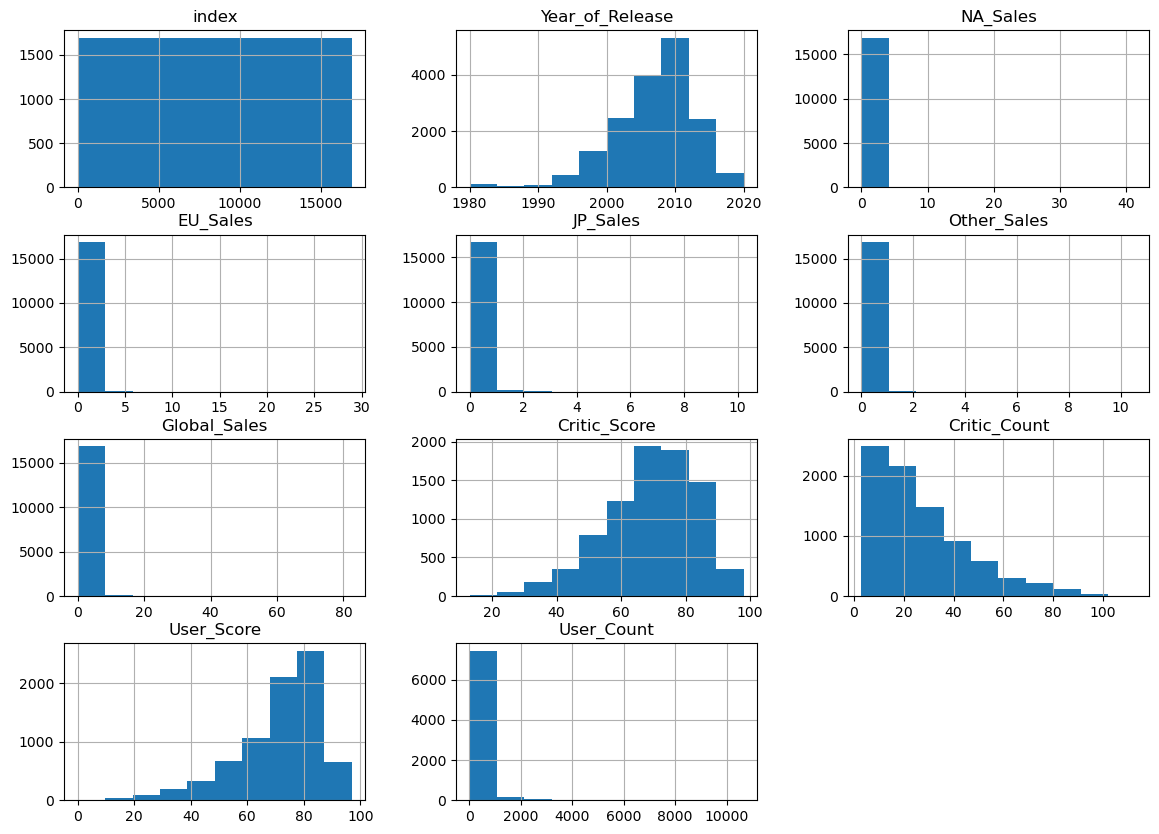

In [9]:
# examine shape of numeric variables
df1.hist(bins=10, figsize=(14, 10))

plt.show()

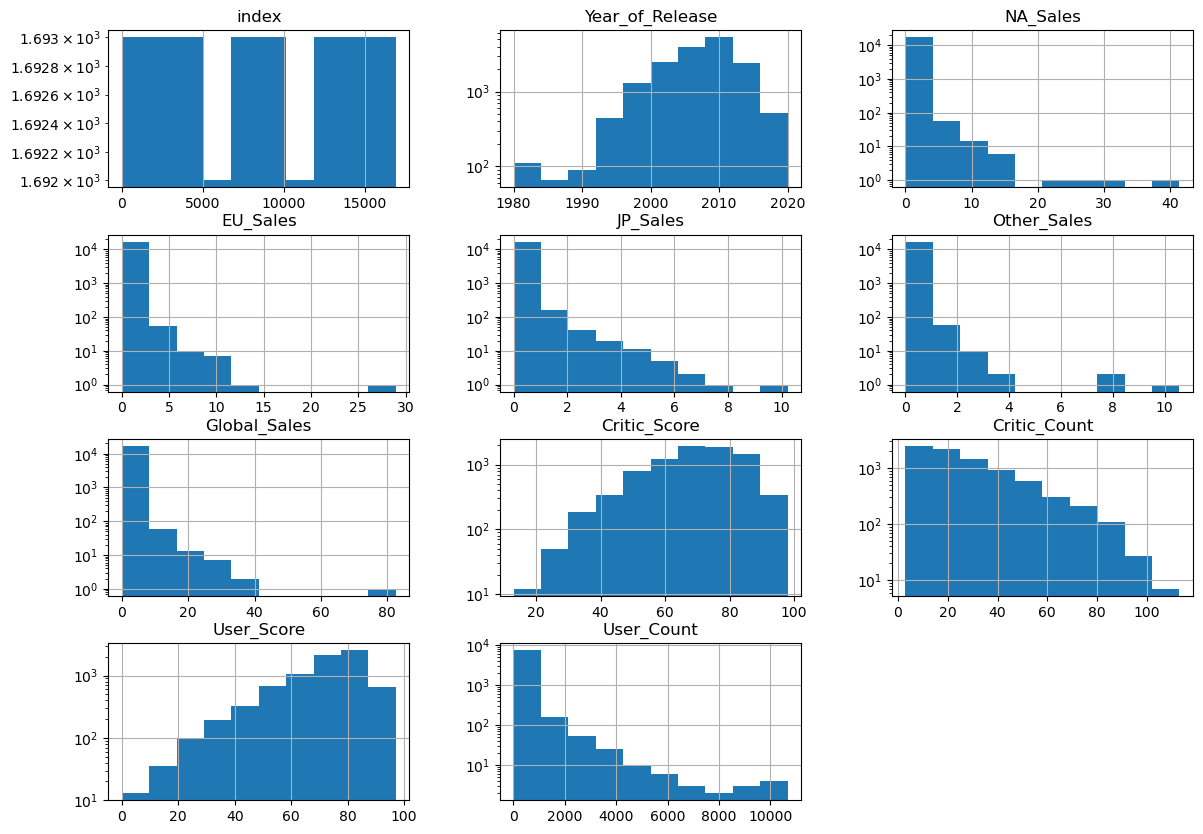

In [10]:
# log transform bar charts and examine again
df1.hist(bins=10, figsize=(14, 10), log=True)
plt.show()

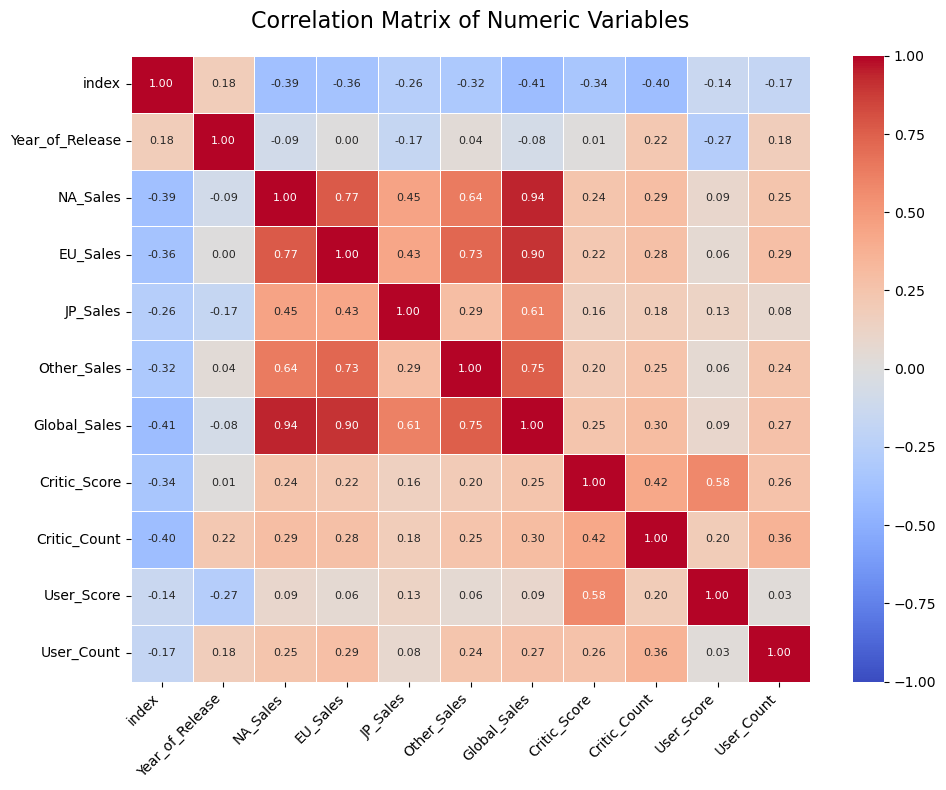

In [11]:
# visualise correlations of numeric variables with a heatmap
corr_matrix = df1.select_dtypes(include=[int, float]).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1, annot_kws={'size': 8})

plt.xticks(rotation=45, ha='right')

plt.title('Correlation Matrix of Numeric Variables', fontsize=16, pad=20)
plt.tight_layout()

In [12]:
# check if null values are disguised as zeros
zero_info = df1.isin([0]).sum().sort_values(ascending=False)
print(zero_info)

JP_Sales           10649
Other_Sales         6643
EU_Sales            5914
NA_Sales            4542
index                  1
User_Score             1
Year_of_Release        0
Genre                  0
Name                   0
Publisher              0
Platform               0
Critic_Score           0
Global_Sales           0
Critic_Count           0
User_Count             0
Developer              0
Rating                 0
dtype: int64


In [13]:
# see what high 0s column looks like
df1_eu0 = df1[df1['EU_Sales'] == 0]
print(df1_eu0.head(10))

     index                             Name Platform  Year_of_Release  \
148    148                Final Fantasy XII      PS2           2006.0   
215    215         Monster Hunter Freedom 3      PSP           2010.0   
268    268  Metal Gear Solid 3: Snake Eater      PS2           2004.0   
284    284                        Half-Life       PC           1997.0   
316    316               Dragon Warrior III      NES           1988.0   
340    340                Friend Collection       DS           2009.0   
349    349        Pro Evolution Soccer 2008      PS2           2007.0   
385    385                 Monster Hunter 4      3DS           2013.0   
388    388                Final Fantasy III     SNES           1994.0   
412    412        Yokai Watch 2 Ganso/Honke      3DS           2014.0   

            Genre                     Publisher  NA_Sales  EU_Sales  JP_Sales  \
148  Role-Playing                   Square Enix      1.88       0.0      2.33   
215  Role-Playing                 

In [14]:
print(df1['Rating'].value_counts().sort_values())

Rating
AO         1
K-A        3
RP         3
EC         8
E10+    1441
M       1590
T       3003
E       4043
Name: count, dtype: int64


In [15]:
# drop low count ratings
values_to_drop = ['AO', 'K-A', 'RP', 'EC']

# drop rows where 'Rating' column contains these values
df1 = df1[~df1['Rating'].isin(values_to_drop)]

# check they've been dropped
print(df1['Rating'].value_counts().sort_values())

Rating
E10+    1441
M       1590
T       3003
E       4043
Name: count, dtype: int64


(16913, 17)
index                 0
Platform              0
NA_Sales              0
EU_Sales              0
Other_Sales           0
Global_Sales          0
JP_Sales              0
Genre                 2
Name                  2
Publisher            55
Year_of_Release     271
Developer          6688
Rating             6836
Critic_Score       8658
Critic_Count       8658
User_Score         9202
User_Count         9202
dtype: int64


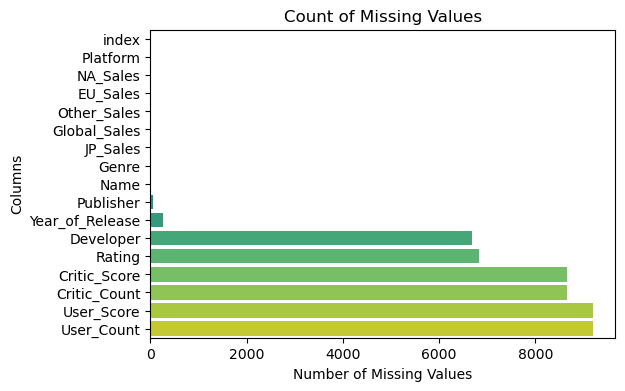

In [16]:
"""count missing values and deal with them"""

# check shape of df1 before nulls removed
print(df1.shape)

# check for missing values
missing_count = df1.isna().sum().sort_values()
print(missing_count)

# change Series into DataFrame to plot
missing_df = missing_count.reset_index()
missing_df.columns = ['Column', 'MissingCount']

# create a bar plot of missing values
plt.figure(figsize=(6, 4))
sns.barplot(x='MissingCount', y='Column', hue='Column', legend=False, data=missing_df, palette="viridis")
plt.title('Count of Missing Values')
plt.xlabel('Number of Missing Values')
plt.ylabel('Columns')
plt.show()

In [17]:
"""Dropping about 60% of the rows, because filling an average for scores and player counts would not be meaningful.
   6935 is still a large enough dataset to make predictions from. However, removing games without ratings may 
   filter out lesser-known games. This could bias our dataset to include only more well-known games."""

# check effect of removing all nulls, with a copy of df1
df2 = df1.copy()
df2 = df2.dropna()

print(df2.shape)
print(df2.info())

(6935, 17)
<class 'pandas.core.frame.DataFrame'>
Index: 6935 entries, 0 to 16926
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            6935 non-null   int64  
 1   Name             6935 non-null   object 
 2   Platform         6935 non-null   object 
 3   Year_of_Release  6935 non-null   float64
 4   Genre            6935 non-null   object 
 5   Publisher        6935 non-null   object 
 6   NA_Sales         6935 non-null   float64
 7   EU_Sales         6935 non-null   float64
 8   JP_Sales         6935 non-null   float64
 9   Other_Sales      6935 non-null   float64
 10  Global_Sales     6935 non-null   float64
 11  Critic_Score     6935 non-null   float64
 12  Critic_Count     6935 non-null   float64
 13  User_Score       6935 non-null   float64
 14  User_Count       6935 non-null   float64
 15  Developer        6935 non-null   object 
 16  Rating           6935 non-null   object 
dtypes: floa

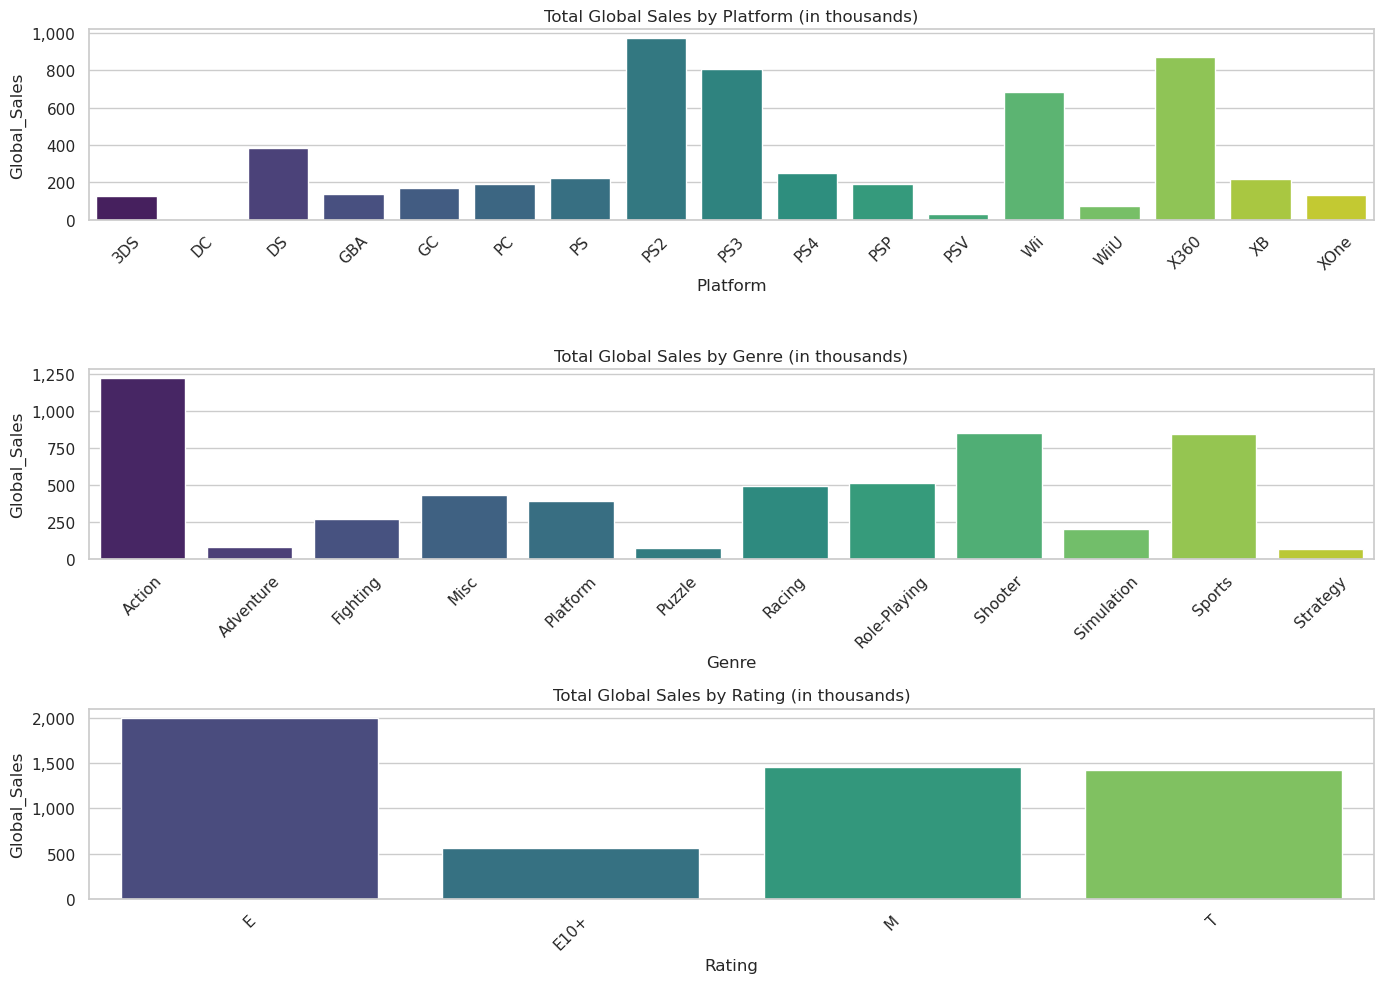

In [18]:
"""Visualising how sales differ by categorical features, in different regions."""

# group global sales by platform, genre and rating
platform_sales = df2.groupby('Platform')['Global_Sales'].sum().reset_index()
genre_sales = df2.groupby('Genre')['Global_Sales'].sum().reset_index()
rating_sales = df2.groupby('Rating')['Global_Sales'].sum().reset_index()

# set the figure size and style
plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")

# format the y-axis with plain numbers (e.g. 1,000,000)
def plain_formatter(x, pos):
    return f'{int(x):,}'

# plotting global sales by Platform column
plt.subplot(3, 1, 1)
sns.barplot(x='Platform', y='Global_Sales', hue='Platform', data=platform_sales, palette='viridis', dodge=False, legend=False)
plt.title('Total Global Sales by Platform (in thousands)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(plain_formatter))

# plotting global sales by Genre column
plt.subplot(3, 1, 2)
sns.barplot(x='Genre', y='Global_Sales', hue='Genre', data=genre_sales, palette='viridis', dodge=False, legend=False)
plt.title('Total Global Sales by Genre (in thousands)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(plain_formatter))

# plotting global sales by Rating column
plt.subplot(3, 1, 3)
sns.barplot(x='Rating', y='Global_Sales', hue='Rating', data=rating_sales, palette='viridis', dodge=False, legend=False)
plt.title('Total Global Sales by Rating (in thousands)')
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(plain_formatter))

plt.tight_layout()
plt.show()

71.85407354001443


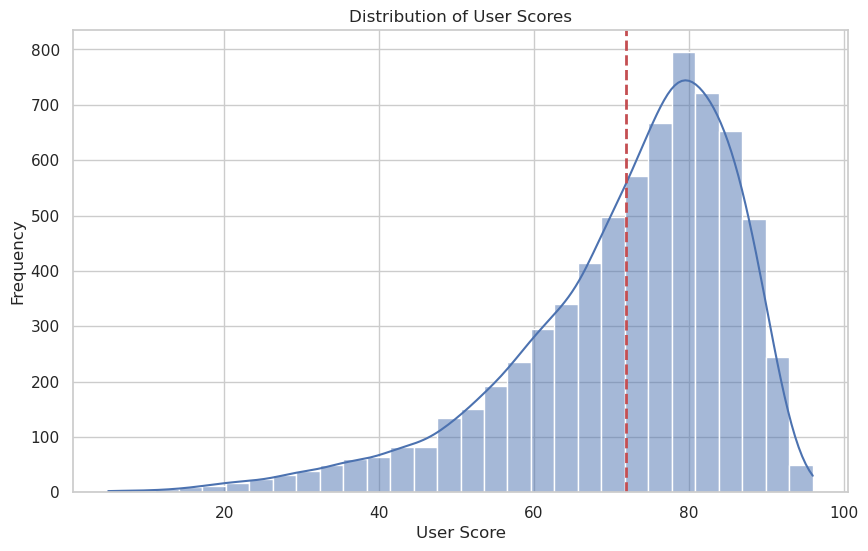

In [19]:
# calculate the mean of User_Score
mean_user_score = df2['User_Score'].mean()
print(mean_user_score)

# histogram for User Score
plt.figure(figsize=(10, 6))
sns.histplot(df2['User_Score'], bins=30, kde=True)
plt.axvline(mean_user_score, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_user_score:.2f}')
plt.title('Distribution of User Scores')
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.show()

70.3179524152848


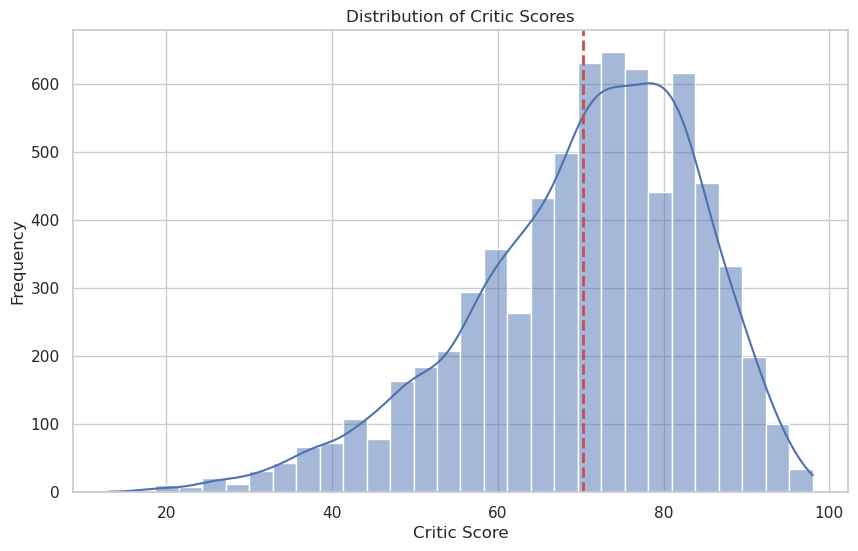

In [20]:
# calculate the mean of Critic_Score
mean_critic_score = df2['Critic_Score'].mean()
print(mean_critic_score)

# histogram for User Score
plt.figure(figsize=(10, 6))
sns.histplot(df2['Critic_Score'], bins=30, kde=True)
plt.axvline(mean_critic_score, color='r', linestyle='--', linewidth=2, label=f'Mean: {mean_critic_score:.2f}')
plt.title('Distribution of Critic Scores')
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.show()

              Critic_Score  User_Score
Critic_Score      1.000000    0.579957
User_Score        0.579957    1.000000


<Axes: >

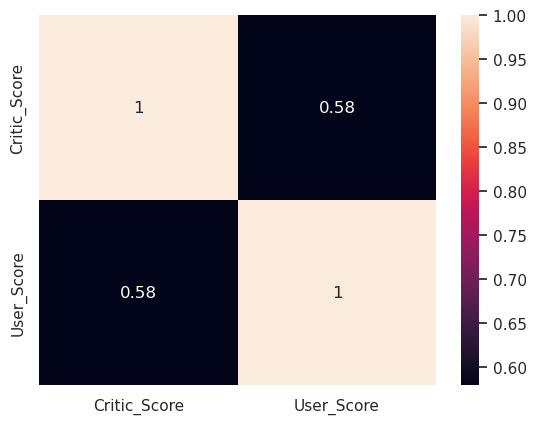

In [21]:
# calculate the correlation between Critic_Score and User_Score
correlation = df2[['Critic_Score', 'User_Score']].corr()

# print and show heatmap
print(correlation)
sns.heatmap(correlation, annot=True)

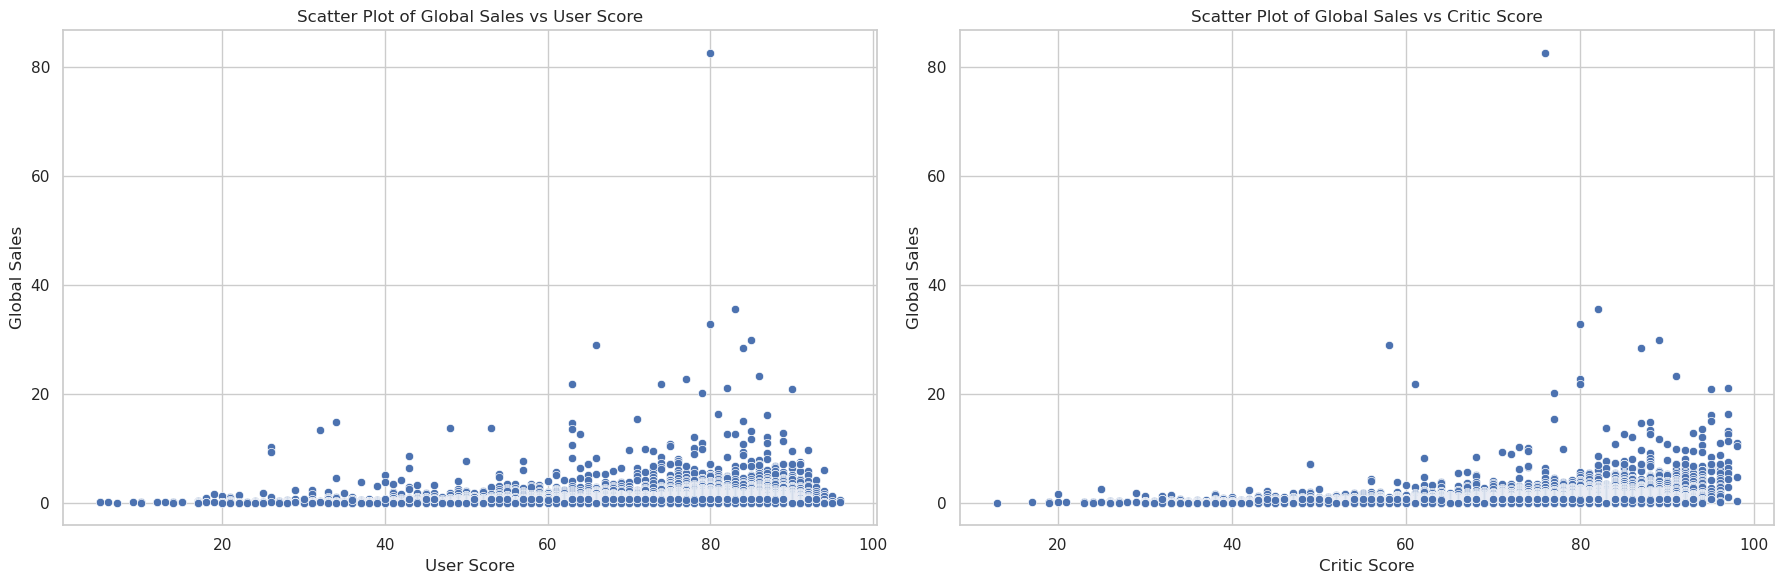

In [22]:
# create a figure for two subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# scatter plot for Global Sales vs User Score
sns.scatterplot(x='User_Score', y='Global_Sales', data=df2, ax=axes[0])
axes[0].set_title('Scatter Plot of Global Sales vs User Score')
axes[0].set_xlabel('User Score')
axes[0].set_ylabel('Global Sales')

# scatter plot for Global Sales vs Critic Score
sns.scatterplot(x='Critic_Score', y='Global_Sales', data=df2, ax=axes[1])
axes[1].set_title('Scatter Plot of Global Sales vs Critic Score')
axes[1].set_xlabel('Critic Score')
axes[1].set_ylabel('Global Sales')

plt.tight_layout()
plt.show()

In [23]:
# check df2
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6935 entries, 0 to 16926
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            6935 non-null   int64  
 1   Name             6935 non-null   object 
 2   Platform         6935 non-null   object 
 3   Year_of_Release  6935 non-null   float64
 4   Genre            6935 non-null   object 
 5   Publisher        6935 non-null   object 
 6   NA_Sales         6935 non-null   float64
 7   EU_Sales         6935 non-null   float64
 8   JP_Sales         6935 non-null   float64
 9   Other_Sales      6935 non-null   float64
 10  Global_Sales     6935 non-null   float64
 11  Critic_Score     6935 non-null   float64
 12  Critic_Count     6935 non-null   float64
 13  User_Score       6935 non-null   float64
 14  User_Count       6935 non-null   float64
 15  Developer        6935 non-null   object 
 16  Rating           6935 non-null   object 
dtypes: float64(10), in

In [24]:
"""Label encoding ratings and One-Hot Encoding remaining categorical variables.
    Dropping name and ID from X."""
# create copies of df2
X = df2.copy()
y = df2.copy()

X = X.drop(columns=['index', 'Name'])
X = X.drop(X.iloc[:, 4:9], axis=1)
y = y.iloc[:, 6:11]
print(y.head())

   NA_Sales  EU_Sales  JP_Sales  Other_Sales  Global_Sales
0     41.36     28.96      3.77         8.45         82.53
2     15.68     12.76      3.79         3.29         35.52
3     15.61     10.93      3.28         2.95         32.77
6     11.28      9.14      6.50         2.88         29.80
7     13.96      9.18      2.93         2.84         28.92


In [25]:
print(X.head())

  Platform  Year_of_Release     Genre Publisher  Critic_Score  Critic_Count  \
0      Wii           2006.0    Sports  Nintendo          76.0          51.0   
2      Wii           2008.0    Racing  Nintendo          82.0          73.0   
3      Wii           2009.0    Sports  Nintendo          80.0          73.0   
6       DS           2006.0  Platform  Nintendo          89.0          65.0   
7      Wii           2006.0      Misc  Nintendo          58.0          41.0   

   User_Score  User_Count Developer Rating  
0        80.0       322.0  Nintendo      E  
2        83.0       709.0  Nintendo      E  
3        80.0       192.0  Nintendo      E  
6        85.0       431.0  Nintendo      E  
7        66.0       129.0  Nintendo      E  


In [26]:
# ratings from youngest to oldest (everyone, 10+, teen, mature)
ratings_order = ['E', 'E10+', 'T', 'M']

# create a dictionary for the custom label encoding
ratings_key = {rating: idx for idx, rating in enumerate(ratings_order)}

# apply the custom label encoding to the 'Rating' column
X['ratings_encoded'] = X['Rating'].map(ratings_key)

# inspect Rating encoding
print(ratings_key)
print("Unique values in 'Rating':", X['Rating'].unique())
print("Unique values in 'ratings_encoded':", X['ratings_encoded'].unique())

# select all remaining categorical columns except 'Rating'
X = X.drop('Rating', axis=1)
cat_cols = X.select_dtypes(include=['object']).columns

# one-hot encode the remaining categorical columns
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# drop any missing values
X_encoded.dropna(inplace=True)

# display the shape and summary of X and X_encoded
print(X.shape)
print(X_encoded.shape)
print("\n", X_encoded.describe())
print("\n", X.head())

{'E': 0, 'E10+': 1, 'T': 2, 'M': 3}
Unique values in 'Rating': ['E' 'M' 'T' 'E10+']
Unique values in 'ratings_encoded': [0 3 2 1]
(6935, 10)
(6935, 1581)

        Year_of_Release  Critic_Score  Critic_Count   User_Score    User_Count  \
count      6935.000000   6935.000000   6935.000000  6935.000000   6935.000000   
mean       2007.440663     70.317952     28.979813    71.854074    176.022927   
std           4.209733     13.871250     19.223734    14.406268    589.247424   
min        1985.000000     13.000000      3.000000     5.000000      4.000000   
25%        2004.000000     62.000000     14.000000    65.000000     11.000000   
50%        2007.000000     72.000000     25.000000    75.000000     27.000000   
75%        2011.000000     81.000000     39.000000    82.000000     89.000000   
max        2016.000000     98.000000    113.000000    96.000000  10665.000000   

       ratings_encoded  
count      6935.000000  
mean          1.462437  
std           1.131654  
min           

In [27]:
# create train/test split for X and y
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5548, 1581) (1387, 1581) (5548, 5) (1387, 5)


In [28]:
# Ridge, RandomForest, Adaboost

# define the parameter grid for the pipeline
param_grid = [
    {
    'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'PCA': [None, PCA(n_components=50, svd_solver='randomized'), PCA(n_components=100, svd_solver='randomized')],
     'model': [MultiOutputRegressor(Ridge())],
     'model__estimator__alpha': [1.0, 10.0, 100],
     'model__estimator__solver': ['auto', 'svd', 'cholesky'],
     'model__estimator__max_iter': [3000, 5000]
     },
     {
    'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'PCA': [None, PCA(n_components=50, svd_solver='randomized'), PCA(n_components=150, svd_solver='randomized')],
     'model': [RandomForestRegressor()],
     'model__n_estimators': [50, 150, 300],
     'model__max_depth': [10, 20, 40],
     'model__min_samples_split': [2, 5, 10],
     'model__min_samples_leaf': [1, 2, 4],
     'model__bootstrap': [True, False]
     },
     {
    'scaler': [MinMaxScaler(), StandardScaler(), RobustScaler()],
    'PCA': [None, PCA(n_components=10, svd_solver='randomized'), PCA(n_components=20, svd_solver='randomized')],
     'model': [MultiOutputRegressor(AdaBoostRegressor())],
     'model__estimator__n_estimators': [50, 150, 300],
     'model__estimator__learning_rate': [0.01, 0.1, 0.5, 1.0],
     'model__estimator__loss': ['linear', 'square'],
     'model__estimator__estimator': [DecisionTreeRegressor(max_depth=2), None]
     },
    
]

In [29]:
# create empty lists to store pipelines and searches
all_pipelines = []
all_searches = []

# add descriptive names to identify models
model_descriptive_names = ['Ridge', 'RandomForest', 'AdaBoost']

# loop over parameters to initialise randomized search cross-validation
for i, params in enumerate(param_grid):
    # get the current model
    model_instance = params['model'][0]

    # get actual model name (rather than overwriting Ridge with Adaboost, both are stored as 'MultiOutputRegressor')
    model_name = model_descriptive_names[i]

    # define our pipeline format
    pipeline = Pipeline([
        ('scaler', None),
        ('PCA', None),
        ('model', model_instance)
    ])

    # drop 'model' from parameter grid for randomized search CV
    model_param_grid = params.copy()
    model_param_grid.pop('model')

    # initialize random search cross-validation
    random_search = RandomizedSearchCV(pipeline, model_param_grid, n_iter=5, cv=5, n_jobs=-1, scoring='r2', verbose=1, random_state=42, return_train_score=True)

    # add results to empty lists
    all_pipelines.append((model_name, pipeline))
    all_searches.append((model_name, random_search))

In [30]:
# create empty results dict
results = {}

for model_name, random_search in all_searches:
    print(f"Training: {model_name}")
    
    # fit our model to the training data
    random_search.fit(X_train, y_train)
    # select model with best parameters and scores
    best_estimator = random_search.best_estimator_
    best_score = random_search.best_score_

    # store results and parameters in results dictionary
    results[model_name] = {
        'best_estimator': best_estimator,
        'best_score': best_score,
        'best_params': random_search.best_params_,
        'cv_results': random_search.cv_results_
    }

    # print scores and parameters
    print(f"  Best score: {best_score:.4f}")
    print(f"  Best parameters: {random_search.best_params_}")
    print("-" * 50)

Training: Ridge
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Best score: 0.2536
  Best parameters: {'scaler': RobustScaler(), 'model__estimator__solver': 'svd', 'model__estimator__max_iter': 3000, 'model__estimator__alpha': 10.0, 'PCA': PCA(n_components=100, svd_solver='randomized')}
--------------------------------------------------
Training: RandomForest
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Best score: 0.3599
  Best parameters: {'scaler': MinMaxScaler(), 'model__n_estimators': 300, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 20, 'model__bootstrap': True, 'PCA': PCA(n_components=150, svd_solver='randomized')}
--------------------------------------------------
Training: AdaBoost
Fitting 5 folds for each of 5 candidates, totalling 25 fits
  Best score: 0.2076
  Best parameters: {'scaler': MinMaxScaler(), 'model__estimator__n_estimators': 150, 'model__estimator__loss': 'linear', 'model__estimator__learning_rat

In [31]:
"""Measure RMSE, MAE, and R² for the models"""

# define model names list for visuals
description_names = ['Ridge', 'Random Forest', 'Adaboost']

# create empty dict to store metrics
metrics_dict = {}

# loop over models to calculate metrics
for i, model_name in enumerate(results.keys()):
    # get model names from list above
    desc_name = description_names[i]

    # store best model as a variable
    best_model = results[model_name]['best_estimator']

    # predict using best model
    y_pred = best_model.predict(X_test)

    # create empty scores lists
    RMSE_scores = []
    MAE_scores = []
    R2_scores = []

    # loop over y_test columns and calculate metrics
    for col_id in range(y_test.shape[1]):
        # calculate RMSE
        mse = mean_squared_error(y_test.iloc[:, col_id], y_pred[:, col_id])
        root_mse = np.sqrt(mse)
        RMSE_scores.append(root_mse)
        
        # calculate MAE
        mae = mean_absolute_error(y_test.iloc[:, col_id], y_pred[:, col_id])
        MAE_scores.append(mae)
        
        # calculate R²
        r2 = r2_score(y_test.iloc[:, col_id], y_pred[:, col_id])
        R2_scores.append(r2)
    
    # store in metrics dict
    metrics_dict[desc_name] = {
        'RMSE': RMSE_scores,
        'MAE': MAE_scores,
        'R2': R2_scores
    }

    # print the metrics
    print(f"Model: {desc_name}")
    for col_id in range(y_test.shape[1]):
        print(f"  Output column {col_id+1}: RMSE = {RMSE_scores[col_id]:.4f}, MAE = {MAE_scores[col_id]:.4f}, R² = {R2_scores[col_id]:.4f}")
    print("-" * 50)

# calculate average metrics across all output columns
for model_name in description_names:
    metrics_dict[model_name]['avg_RMSE'] = np.mean(metrics_dict[model_name]['RMSE'])
    metrics_dict[model_name]['avg_MAE'] = np.mean(metrics_dict[model_name]['MAE'])
    metrics_dict[model_name]['avg_R2'] = np.mean(metrics_dict[model_name]['R2'])
    
    print(f"Model: {model_name}")
    print(f"  Average RMSE: {metrics_dict[model_name]['avg_RMSE']:.4f}")
    print(f"  Average MAE: {metrics_dict[model_name]['avg_MAE']:.4f}")
    print(f"  Average R²: {metrics_dict[model_name]['avg_R2']:.4f}")
    print("-" * 50)

Model: Ridge
  Output column 1: RMSE = 0.7304, MAE = 0.3534, R² = 0.2987
  Output column 2: RMSE = 0.4805, MAE = 0.2295, R² = 0.2901
  Output column 3: RMSE = 0.1956, MAE = 0.0841, R² = 0.2469
  Output column 4: RMSE = 0.1710, MAE = 0.0825, R² = 0.2791
  Output column 5: RMSE = 1.3303, MAE = 0.6675, R² = 0.3252
--------------------------------------------------
Model: Random Forest
  Output column 1: RMSE = 0.6826, MAE = 0.2998, R² = 0.3874
  Output column 2: RMSE = 0.4591, MAE = 0.2080, R² = 0.3519
  Output column 3: RMSE = 0.1842, MAE = 0.0650, R² = 0.3319
  Output column 4: RMSE = 0.1652, MAE = 0.0710, R² = 0.3275
  Output column 5: RMSE = 1.2539, MAE = 0.5704, R² = 0.4004
--------------------------------------------------
Model: Adaboost
  Output column 1: RMSE = 0.7650, MAE = 0.3568, R² = 0.2308
  Output column 2: RMSE = 0.5031, MAE = 0.2338, R² = 0.2219
  Output column 3: RMSE = 0.2062, MAE = 0.0833, R² = 0.1631
  Output column 4: RMSE = 0.2442, MAE = 0.0985, R² = -0.4694
  Outpu

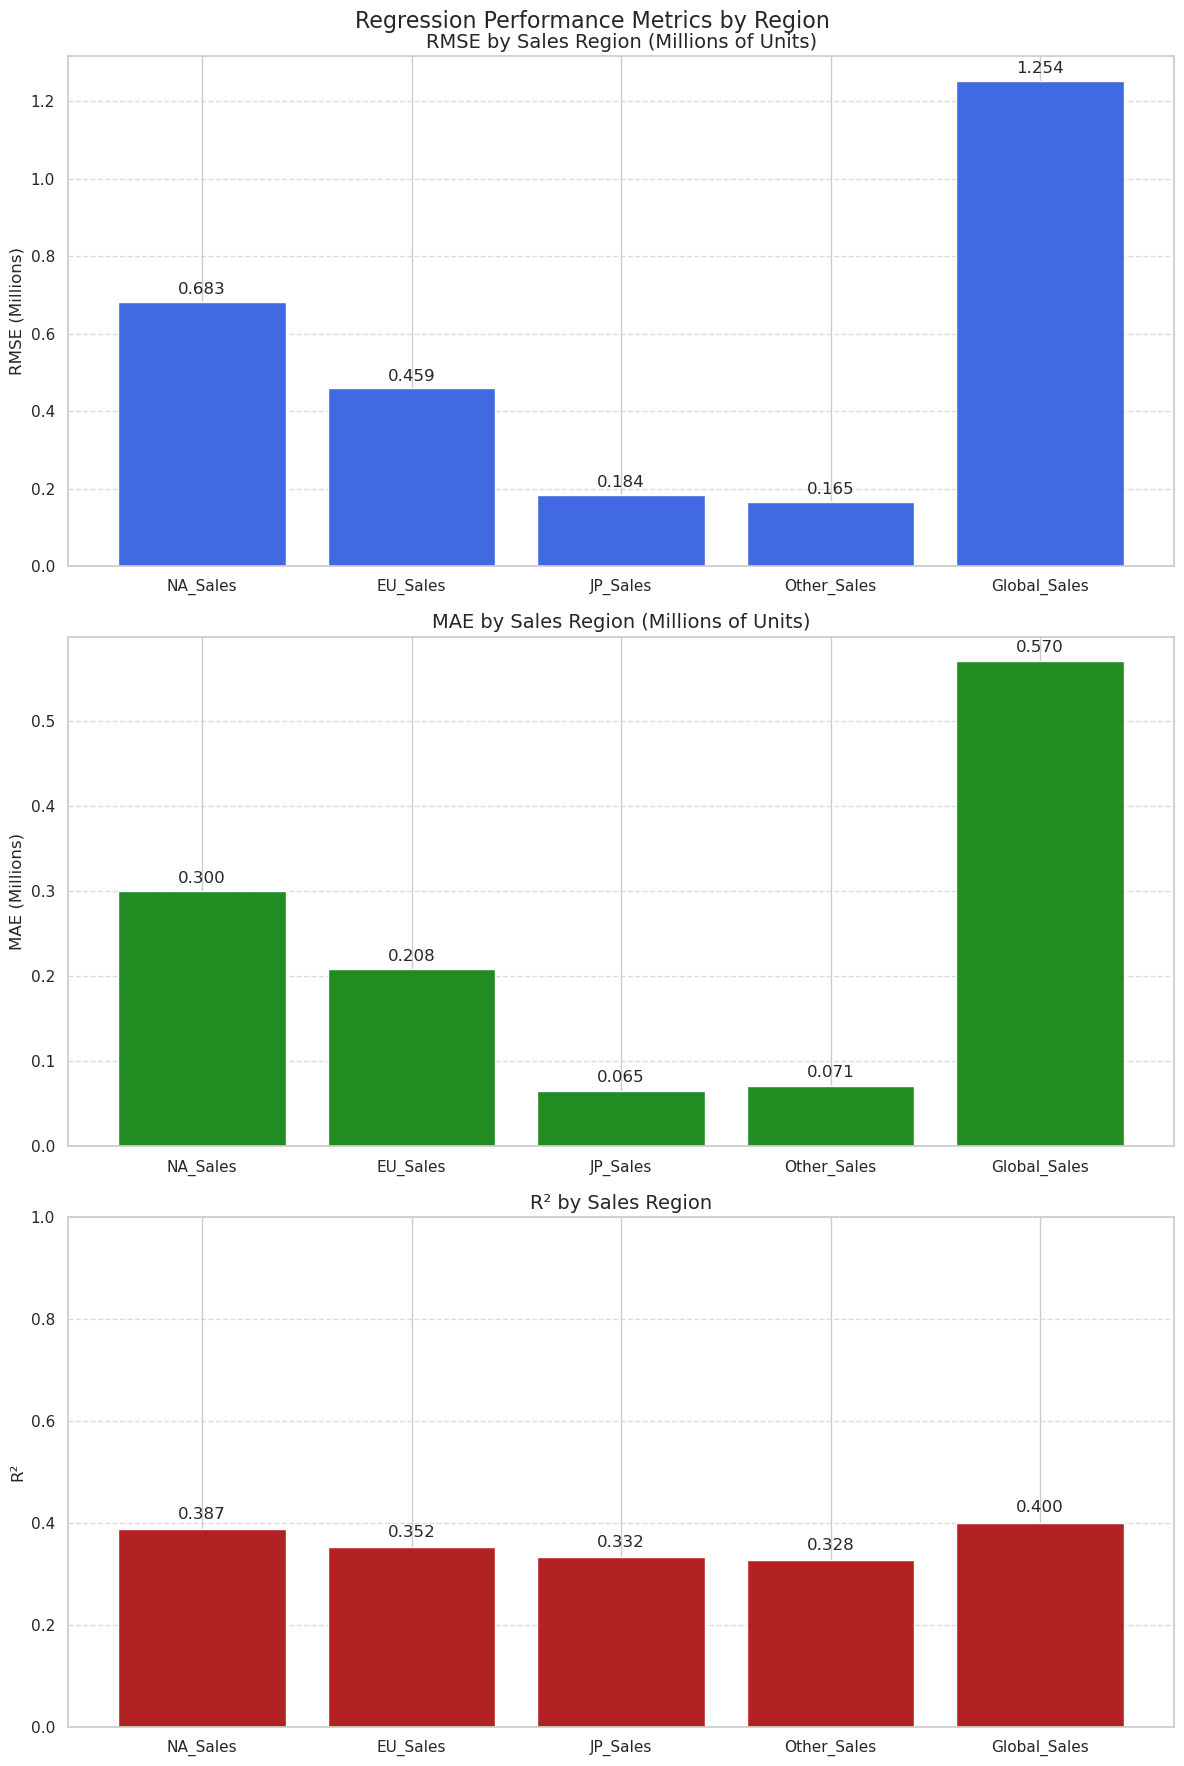

In [ ]:
# define the target column names
target_column_names = ['NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales']

# use metrics from random forest, the best performing model
rf_metrics = metrics_dict['Random Forest']

# create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))

# plot RMSE values
axes[0].bar(target_column_names, rf_metrics['RMSE'], color='royalblue')
axes[0].set_title('RMSE by Sales Region (Millions of Units)', fontsize=14)
axes[0].set_ylabel('RMSE (Millions)', fontsize=12)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(rf_metrics['RMSE']):
    axes[0].text(i, v + 0.02, f"{v:.3f}", ha='center')

# plot MAE values
axes[1].bar(target_column_names, rf_metrics['MAE'], color='forestgreen')
axes[1].set_title('MAE by Sales Region (Millions of Units)', fontsize=14)
axes[1].set_ylabel('MAE (Millions)', fontsize=12)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(rf_metrics['MAE']):
    axes[1].text(i, v + 0.01, f"{v:.3f}", ha='center')

# plot R2 values
axes[2].bar(target_column_names, rf_metrics['R2'], color='firebrick')
axes[2].set_title('R² by Sales Region', fontsize=14)
axes[2].set_ylabel('R²', fontsize=12)
axes[2].set_ylim(0, 1)
axes[2].grid(axis='y', linestyle='--', alpha=0.7)
for i, v in enumerate(rf_metrics['R2']):
    axes[2].text(i, v + 0.02, f"{v:.3f}", ha='center')

# add an overall title
plt.suptitle('Regression Performance Metrics by Region', fontsize=16, y=0.98)

plt.tight_layout()
plt.show()